<a href="https://colab.research.google.com/github/DanielDLX/DLfinal/blob/master/RNN_AGnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# 导入包
# transformer提供了一些训练好的模型，可以很方便的使用。
!pip install transformers
import tensorflow as tf
import pandas as pd
import os
import tqdm
# 使用分类的模型，增加了一个head用于分类。
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import numpy as np
% matplotlib inline

tf.__version__

'2.2.0'

In [2]:
# 导入现成的模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4, output_hidden_states=True) # 分类类别数
model.summary()
model.config

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3076      
Total params: 109,485,316
Trainable params: 109,485,316
Non-trainable params: 0
_________________________________________________________________


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [3]:
# 简单分类算法
# 把模型改成了最简单的rnn，embedding长度改成了768，因为bert的是768，求余弦相似度的时候需要维度相同
model_compare  = tf.keras.Sequential([
    tf.keras.layers.Embedding(30522, 768),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4)
])
model_compare.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 768)         23440896  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               114816    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 23,564,228
Trainable params: 23,564,228
Non-trainable params: 0
_________________________________________________________________


In [4]:
# 数据链接，可以在 https://course.fast.ai/datasets 找到。
# agnews数据集，类别，标题，描述。
ag_url = 'https://s3.amazonaws.com/fast-ai-nlp/ag_news_csv.tgz'

In [5]:
# 下载数据，并指定此时数据集的目录
ag_zip_file = tf.keras.utils.get_file(origin=ag_url,fname='ag_news_csv.tgz', extract=True)
base_dir = os.path.join(os.path.dirname(ag_zip_file), 'ag_news_csv')
os.listdir(base_dir)

11788288/11784419 [==============================] - 1s 0us/step


['readme.txt', 'classes.txt', 'test.csv', 'train.csv']

In [6]:
# 读取数据
# 为了方便测试代码的时候少用几个数据,1000个数据可以让准确率上升到0.68
num = 1000
train = pd.read_csv(os.path.join(base_dir, 'train.csv'), header=None)
train = train.sample(n=num)
print(len(train))
print(train.head())
test = pd.read_csv(os.path.join(base_dir, 'test.csv'), header=None)
test = test.sample(n=num)
print(len(test))
print(test.head())
f = open(os.path.join(base_dir, 'classes.txt'))
classes = f.readlines()
classes = [s.strip() for s in classes]
print(classes)

1000
        0  ...                                                  2
108977  3  ...  Reuters - Wal-Mart Stores Inc. , the\world's l...
50177   4  ...  AP - The rumblings, the steady earthquakes, th...
25273   4  ...  RealNetworks says it sold more than three mill...
101251  4  ...  Online phishing schemes more than doubled last...
39550   2  ...  Mets rookie Victor Diaz stroked a tying three-...

[5 rows x 3 columns]
1000
      0  ...                                                  2
2764  4  ...  MacCentral - Apple has improved the services o...
4250  1  ...  AP - President Bush and Sen. John Kerry are lo...
7045  3  ...  America West Holdings Corp., parent of America...
1044  3  ...  Another disappointing sales month at General M...
4290  1  ...   TOKYO (Reuters) - As the death toll rose from...

[5 rows x 3 columns]
['World', 'Sports', 'Business', 'Sci/Tech']


In [7]:
# 预处理数据
# 按照上面的例子把数据集中的文本进行分词处理，并且得到对应的labels。
max_length = 256
max_length_temp = max_length - 2
train_ids = []
test_ids = []
for i in tqdm.notebook.trange(train.shape[0]):
  if len(train[2][train[2].index[i]]) > max_length_temp:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
for i in tqdm.notebook.trange(test.shape[0]):
  if len(test[2][test[2].index[i]]) > max_length_temp:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
train_labels = train[0].values - 1
test_labels = test[0].values - 1

In [8]:
# 把数据转成tensorflow张量
# train_ids是tf.Tensor组成得列表，所以用concat组合一下就行
train_ids = tf.concat(train_ids, 0)
# 把train_mask初始化为1，然后把train_ids等于0（PAD的部分）对应的值赋为0
train_mask = tf.ones(train_ids.shape)
train_mask = tf.where(tf.math.greater(train_ids, 0), train_mask, 0)
# labels本身是numpy数组，转为tf.Tensor
train_labels = tf.convert_to_tensor(train_labels)

# 测试集的处理同理test
test_ids = tf.concat(test_ids, 0)
test_mask = tf.ones(test_ids.shape)
test_mask = tf.where(tf.math.greater(test_ids, 0), test_mask, 0)
test_labels = tf.convert_to_tensor(test_labels)

In [9]:
print(train_ids[0])
print(train_mask[0])
print(train_labels[0])

tf.Tensor(
[  101 26665  1011 24547  1011 20481  5324  4297  1012  1010  1996  1032
  2088  1005  1055  2922 20196  1010  2056  2006  5095  2009  2145 24273
  1037  1015  1032  3867  2000  1017  3867  3623  1999  2285  4341  2012
  2049  1057  1012  1055  1012  1032  5324  2330  2012  2560  1037  2095
  1012   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [10]:
# 训练参数
epochs = 3
batch_size = 16
validation_rate = 0.1

In [11]:
# 模型编译
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model_compare.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [12]:
# 模型训练
history = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=None,
     shuffle=True)

Epoch 1/3
63/63 [==============================] - 100s 2s/step - loss: 0.7710 - accuracy: 0.7610
Epoch 2/3
63/63 [==============================] - 100s 2s/step - loss: 0.2670 - accuracy: 0.9180
Epoch 3/3
63/63 [==============================] - 100s 2s/step - loss: 0.1211 - accuracy: 0.9670


In [13]:
history_compare = model_compare.fit(
    x=[train_ids, train_mask],
    y=train_labels,
    batch_size=batch_size, 
    epochs=epochs,
    verbose=1,
    callbacks=None,
    shuffle=True
)

Epoch 1/3
63/63 [==============================] - 30s 483ms/step - loss: 1.3920 - accuracy: 0.6160
Epoch 2/3
63/63 [==============================] - 30s 483ms/step - loss: 1.3912 - accuracy: 0.2610
Epoch 3/3
63/63 [==============================] - 30s 480ms/step - loss: 1.3886 - accuracy: 0.2620


In [14]:
# 模型测试
model.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=16, 
        verbose=1)

250/250 [==============================] - 40s 158ms/step - loss: 0.3899 - accuracy: 0.8830


[0.3899320065975189, 0.8830000162124634]

In [15]:
model_compare.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=16, 
        verbose=1)

63/63 [==============================] - 2s 39ms/step - loss: 1.3862 - accuracy: 0.2460


[1.3861782550811768, 0.2460000067949295]

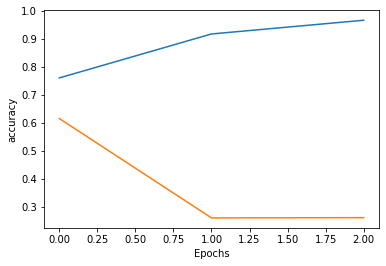

In [16]:
# 画图
def plot_graphs(history,history_compare, metric):
  plt.plot(history.history[metric])
  plt.plot(history_compare.history[metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.show()
plot_graphs(history, history_compare, 'accuracy')

In [40]:
# 得到RNN模型embedding的方法，get embedding层后，输入词的id，得到embeding
embedding_compare = model_compare.get_layer('embedding')

In [45]:
# 得到每个类的embedding
avg_pool1 = tf.keras.layers.AveragePooling2D(pool_size=(max_length, 1))
embs = embedding_compare(train_ids)
seq_embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,256,768,1])), [-1,768])
class_embedding_compare = np.zeros([4,768])
for i in range(4):
  index = train_labels == i
  class_embs = seq_embs[index]
  avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(tf.shape(class_embs)[0], 1))
  class_embs = tf.reshape(class_embs,[1,-1,768,1])
  class_embs = avg_pool2(class_embs)
  class_embedding_compare[i] = tf.reshape(class_embs, [768]).numpy()
print(class_embedding_compare)

[[ 0.03516304 -0.01918756 -0.01195849 ... -0.0040265   0.01464068
  -0.02265337]
 [ 0.03523726 -0.01942924 -0.01180148 ... -0.00386236  0.01458916
  -0.02232433]
 [ 0.03457531 -0.0189842  -0.01196213 ... -0.00381166  0.01454298
  -0.02241232]
 [ 0.03481458 -0.01900793 -0.01200404 ... -0.00386193  0.01458429
  -0.02242165]]


In [46]:
# 获得bert Embedding的方式，这里得到是整个embedding张量
embeddings = model.get_layer('bert').embeddings.word_embeddings

# 定义函数：通过词id 得到embedding
def get_embedding(input_ids, embeddings=embeddings):
  embeds = tf.gather(embeddings, input_ids)
  return embeds

In [52]:
# 得到每个类的embedding
embs = get_embedding(train_ids)
seq_embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,256,768,1])), [-1,768])
class_embedding = np.zeros([4,768])
for i in range(4):
  index = train_labels == i
  class_embs = seq_embs[index]
  avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(tf.shape(class_embs)[0], 1))
  class_embs = tf.reshape(class_embs,[1,-1,768,1])
  class_embs = avg_pool2(class_embs)
  class_embedding[i] = tf.reshape(class_embs, [768]).numpy()
print(class_embedding)

[[-0.01131212 -0.05420418 -0.02503383 ... -0.01909326 -0.03375822
  -0.0093208 ]
 [-0.01119877 -0.05428385 -0.02463109 ... -0.01920241 -0.03372704
  -0.00942201]
 [-0.01131681 -0.05474619 -0.0250214  ... -0.01884219 -0.03264961
  -0.00903403]
 [-0.01142444 -0.05421361 -0.02499715 ... -0.01872167 -0.03273422
  -0.00913916]]
